In [41]:
%matplotlib inline
import numpy as np
import collections
import os
import re
import sys
import math

from nltk.stem.lancaster import LancasterStemmer

In [42]:
'''
Loads the Congressional Speech Data with labels
@param root_dir Root directory of the files containing the speech text data
Returns [(unigrams, bigrams, outcome=0/1)...]
'''

def load_raw_data(root_dir, stop_word_file, skip_label=False):
    result = []
    stop_words = set([])
    # Any shorter implies insufficient data
    MIN_WORDS = 5
    st = LancasterStemmer()

    if stop_word_file != None:
        with open(stop_word_file) as f:
            stop_words = set([line.strip() for line in f.readlines()])
    
    for file_name in os.listdir(root_dir):
        if file_name.endswith(".txt"):
            file_path = os.path.join(root_dir, file_name)
            txt = None
            
            with open(file_path) as f:
                txt = f.read()
            
            raw_words = []
            
            # A little cleanup for punctuations and case 
            for unclean_word in filter(None, re.split("[\]\[\)\(\"\'\n,\-\.!?: ]+", txt)):
                word = str.lower(unclean_word.strip())
                # Random codecs can mess this
                if len(word) > 2:
                    raw_words.append(word)
                
            # Skip comments that are too short
            if len(raw_words) < MIN_WORDS:
                continue
                
            # Unigrams
            unigrams = [word for word in raw_words if word not in stop_words]
            bigrams = ["%s %s" % (raw_words[i], raw_words[i+1]) for i in range(len(raw_words) - 1)]
            trigrams = ["%s %s %s" % (raw_words[i], raw_words[i+1], raw_words[i+2]) for i in range(len(raw_words) - 2)]
            words = unigrams + bigrams + trigrams

            yt = 0

            # Outcome
            # If skip_label is True, all labels are 0.
            if not skip_label:
                label = file_name.split(".")[0][-1]

                if label == 'Y':
                    yt = 1

            result.append((words, yt, file_path))
            
    return result

'''
Returns
X: [[unigrams + bigrams in review],...]
y: outcomes [0,1,1,0...]
cache: { "word" : [#0s where it appears, #1s where it appears]}
'''
def load_data(root_dir, stop_word_file=None, extract_names=False, print_every=100):
    raw_data = load_raw_data(root_dir, stop_word_file)
    X = [[] for rd in raw_data]
    y = [0 for rd in raw_data]
    names = [(None, None) for rd in raw_data]
    file_paths = [None for rd in raw_data]
   
    cache = {}
    n = len(raw_data)
    
    for i, sample in enumerate(raw_data):
        if i%print_every == 0:
            print("Processing %d/%d" % (i+1, n))
            sys.stdout.flush()
            
        words, outcome, file_path = sample
        
        # Just a good approximation.
        if extract_names:
            names[i] = (words[0], words[1])
            words = words[2:]
            
        X[i] = words
        y[i] = outcome
        file_paths[i] = file_path
        
        for word in words:
            if word not in cache:
                cache[word] = [0,0]
            
            cache[word][outcome] += 1
    
    return np.array(X), np.array(y), cache, np.array(names), file_paths

In [43]:
'''
DATA_ROOT="/Users/vikesh/development/opt/convote_v1.1/data_stage_three/"
TRAIN_ROOT=os.path.join(DATA_ROOT, "training_set")
DEV_ROOT=os.path.join(DATA_ROOT, "development_set")
TEST_ROOT=os.path.join(DATA_ROOT, "test_set")
STOP_WORDS_FILE="stop-word-list.txt"
'''
DIR_ROOT=""
MODEL_ROOT=os.path.join(DIR_ROOT, "model")
TRAIN_ROOT=os.path.join(MODEL_ROOT, "train")
DEV_ROOT=os.path.join(MODEL_ROOT, "dev")
TEST_ROOT=os.path.join(MODEL_ROOT, "test")

DATA_ROOT=os.path.join(DIR_ROOT, "data")
FIRST_NAMES_ROOT=os.path.join(DIR_ROOT, "names")
LAST_NAMES_FILE=os.path.join(DIR_ROOT, "names_census", "app.txt")
STOP_WORDS_FILE="stop-word-list.txt"

In [44]:
print("Loading data...")
# No names in train/dev/test set
X_train, y_train, cache_train, names_null, file_paths_train = load_data(TRAIN_ROOT, STOP_WORDS_FILE)
X_dev, y_dev, cache_dev, names_null ,file_paths_dev = load_data(DEV_ROOT, STOP_WORDS_FILE)
X_test, y_test, cache_test, names_null, file_paths_test = load_data(TEST_ROOT, STOP_WORDS_FILE)
print("Loaded all data.")

assert len(X_train) == len(y_train)
print("Num train samples: %d" % len(X_train))
print("Num -ive samples: %d" % np.sum(y_train==0))
print("Num +ive samples: %d" % np.sum(y_train==1))
print("Vocab: %d" % len(cache_train))

Loading data...
Processing 1/532
Processing 101/532
Processing 201/532
Processing 301/532
Processing 401/532
Processing 501/532
Processing 1/146
Processing 101/146
Processing 1/75
Loaded all data.
Num train samples: 532
Num -ive samples: 201
Num +ive samples: 331
Vocab: 65247


In [45]:
def naive_bayes(X, y, cache):
    V = len(cache)
    K=1.0
    cnts = [np.sum(y==0), np.sum(y==1)]
    
    P = collections.defaultdict(lambda  : [K/(cnts[0] + K*V), K/(cnts[1] + K*V)])
    Pc = [cnts[0]/float(len(y)), cnts[1]/float(len(y))]
    
    for word, counts in cache.iteritems():
        for i, count in enumerate(counts):
            # With laplace 1 smoothing
            P[word][i] = float(count + K) / (cnts[i] + K*V)
            
    return P, Pc

def evaluate(x, P, Pc):
    lnps = [0,0]
    
    for i in range(0, 2):
        lnps[i] = math.log(Pc[i]) + np.sum(np.log([P[word][i] for word in x]))
    
    return np.argmax(lnps)

In [46]:
P, Pc = naive_bayes(X_train, y_train, cache_train)

In [47]:
def test(X, P, Pc):
    # Compute dev accuracy
    y_eval = []

    for x_eval in X:
        y_eval.append(evaluate(x_eval, P, Pc))

    return np.array(y_eval)

# Fill the cache based on eval
def backfill(X, y):
    cache = collections.defaultdict(lambda : [0,0])
    for i, x in enumerate(X):
        for word in x:
            cache[word][y[i]] += 1
            
    return cache

In [48]:
# Compute train accuracy
print("Train set accuracy: %f" % np.mean(test(X_train, P, Pc)==y_train))
# Compute dev accuracy
print("Dev set accuracy: %f" % np.mean(test(X_dev, P, Pc)==y_dev))
# Compute test accuracy
print("Test set accuracy: %f" % np.mean(test(X_test, P, Pc)==y_test))

Train set accuracy: 1.000000
Dev set accuracy: 0.924658
Test set accuracy: 0.906667


In [49]:
X_data, y_data, cache_data, names_data, file_paths_data = load_data(DATA_ROOT, STOP_WORDS_FILE, extract_names=True, print_every=1000)
assert(len(X_data) == len(y_data))
print("Loaded real data. Total=%d" % len(y_data))

Processing 1/75
Loaded real data. Total=75


In [50]:
# This is the real y_data
y_eval = test(X_data, P, Pc)
# Backfill the cache to have proper counts
cache_data = backfill(X_data, y_eval)

In [51]:
## Scatch space
def toFile(x):
    tmp = "/tmp/data.txt"
    with open(tmp, "w") as f:
        f.writelines(x)
            
    print tmp

In [52]:
# Load the US names database
# Returns the cache of name to its occurence in the DB
def load_first_names(names_root, start_year=None, end_year=None):
    cache = collections.defaultdict(int)
    
    for file_name in os.listdir(names_root):
        if file_name.endswith(".txt"):
            file_path = os.path.join(names_root, file_name)
            year = int(file_name.split(".")[0][-4:])
            
            if start_year != None and year < start_year:
                continue
            if end_year != None and year > end_year:
                continue
                
            names = []
            
            with open(file_path) as f:
                for line in f.readlines():
                    name, sex, occ_cnt = line.strip().split(",")
                    cache[str.lower(name)] += long(occ_cnt)
            
    
    return cache

def load_last_names(names_file):
    cache = collections.defaultdict(int)
    
    with open(names_file, "r") as f:
        for line in f.readlines():
            if not line.startswith("#"):
                data = line.strip().split()
                cache[str.lower(data[0])] = long(data[2])
            
    return cache

In [53]:
# Load data necessary to compute stats
first_name_cache = load_first_names(FIRST_NAMES_ROOT, start_year=1900)
last_name_cache = load_last_names(LAST_NAMES_FILE)
print("Loaded %s first names" % len(first_name_cache))
print("Loaded %s last names" % len(last_name_cache))

Loaded 93837 first names
Loaded 151671 last names


In [54]:
# Stats: Percentage of Yays and Nays
cnt_yes = np.sum(y_eval == 1)
cnt_no = np.sum(y_eval == 0)

print("Number of YES=%d, NO=%d" % (cnt_yes, cnt_no))
print("Percentage of YES=%f, NO=%f" % (float(cnt_yes)/len(y_eval), float(cnt_no)/len(y_eval)))

Number of YES=54, NO=21
Percentage of YES=0.720000, NO=0.280000


In [55]:
# Source: http://www.bloomberg.com/visual-data/best-and-worst//most-common-in-china-surnames 
with open(os.path.join(MODEL_ROOT, "chinese_names.txt"), "r") as f:
    TOP_ASIAN_NAMES = set([str.lower(line.strip()) for line in f.readlines()])
    
# Source: Wikipedia, and manually eyeballing the data
with open(os.path.join(MODEL_ROOT, "indian_names.txt"), "r")  as f:
    TOP_INDIAN_NAMES = set([str.lower(line.strip()) for line in f.readlines()])

In [56]:
# Stats: How many names (approximately) are from US citizens/residents
def get_amr(names, first_name_cache, last_name_cache, percentile, exclude_intl_names=True):
    min_occ_first = np.percentile([occ_cnt for name, occ_cnt in first_name_cache.iteritems()], percentile)
    min_occ_last = np.percentile([occ_cnt for name, occ_cnt in last_name_cache.iteritems()], percentile)
    
    amr = np.zeros(len(names))
    
    for i, name in enumerate(names):
        # This is a good approximation
        try:
            first_name, last_name = name
            # Probability of US name
            is_name_us = (first_name_cache[first_name] > min_occ_first and last_name_cache[last_name] > min_occ_last)
            is_name_not_intl = last_name not in TOP_ASIAN_NAMES and last_name not in TOP_INDIAN_NAMES
            amr[i] = is_name_us and (not exclude_intl_names or is_name_not_intl)
        except:
            print("WARNING: Bad data. Skipping.")
            
    return amr

# Excluding intl names: False
# Percentile	US ratio	US among +ve	US among -ve	+ve among US	-ve among US
60.000	0.000	0.000	0.000	nan	nan
75.000	0.000	0.000	0.000	nan	nan
80.000	0.000	0.000	0.000	nan	nan
85.000	0.000	0.000	0.000	nan	nan
88.000	0.000	0.000	0.000	nan	nan
90.000	0.000	0.000	0.000	nan	nan
91.000	0.000	0.000	0.000	nan	nan
92.000	0.000	0.000	0.000	nan	nan
93.000	0.000	0.000	0.000	nan	nan
94.000	0.000	0.000	0.000	nan	nan
95.000	0.000	0.000	0.000	nan	nan
96.000	0.000	0.000	0.000	nan	nan
97.000	0.000	0.000	0.000	nan	nan
98.000	0.000	0.000	0.000	nan	nan
99.000	0.000	0.000	0.000	nan	nan


/Library/Python/2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide


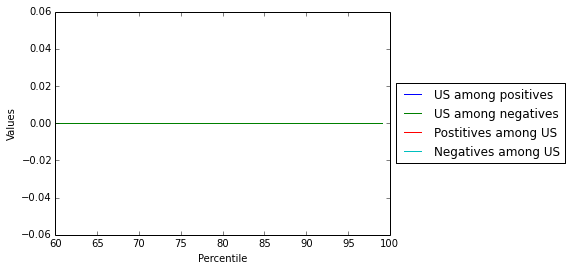

# Excluding intl names: True
# Percentile	US ratio	US among +ve	US among -ve	+ve among US	-ve among US
60.000	0.000	0.000	0.000	nan	nan
75.000	0.000	0.000	0.000	nan	nan
80.000	0.000	0.000	0.000	nan	nan
85.000	0.000	0.000	0.000	nan	nan
88.000	0.000	0.000	0.000	nan	nan
90.000	0.000	0.000	0.000	nan	nan
91.000	0.000	0.000	0.000	nan	nan
92.000	0.000	0.000	0.000	nan	nan
93.000	0.000	0.000	0.000	nan	nan
94.000	0.000	0.000	0.000	nan	nan
95.000	0.000	0.000	0.000	nan	nan
96.000	0.000	0.000	0.000	nan	nan
97.000	0.000	0.000	0.000	nan	nan
98.000	0.000	0.000	0.000	nan	nan
99.000	0.000	0.000	0.000	nan	nan


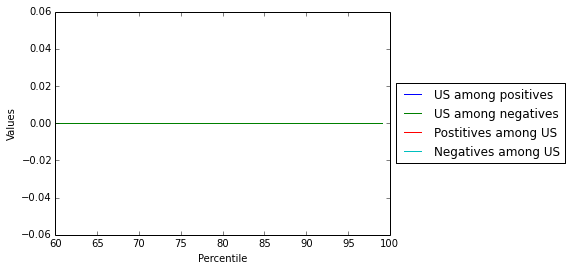

In [57]:
import matplotlib.pyplot as plt

PERCENTILES = [60, 75, 80, 85, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

for exclude_intl_names in [False, True]:
    print("# Excluding intl names: {}".format(exclude_intl_names))
    print("# Percentile\tUS ratio\tUS among +ve\tUS among -ve\t+ve among US\t-ve among US")
    plt_percentiles = []
    plt_US_pos = []
    plt_US_neg = []
    plt_pos_US = []
    plt_neg_US = []

    for percentile in PERCENTILES:
        amr = get_amr(names_data, first_name_cache, last_name_cache, percentile, exclude_intl_names)

        with open("results/perc.%f.txt" % percentile, "w") as f:
            for i, name in enumerate(names_data):
                if amr[i] == 1:
                    f.write(str(amr[i]) + ", " + str(names_data[i]) + ", VOTE=" + str(y_eval[i]) + "\n")
                    f.write(" ".join(X_data[i]) + "\n")
                    f.write("*******\n")

        plt_percentiles.append(percentile)
        plt_US_pos.append(np.sum(y_eval[amr==1])/float(np.sum(y_eval==1)))
        plt_US_neg.append(np.sum((1-y_eval)[amr==1])/float(np.sum(1-y_eval)))
        plt_pos_US.append(np.sum(y_eval[amr==1])/float(np.sum(amr)))
        plt_neg_US.append(np.sum((1-y_eval)[amr==1])/float(np.sum(amr==1)))

        print("{0:0.3f}\t{1:0.3f}\t{2:0.3f}\t{3:0.3f}\t{4:0.3f}\t{5:0.3f}".format(
                percentile,
                np.sum(amr==1)/float(len(y_eval)),
                plt_US_pos[-1],
                plt_US_neg[-1],
                plt_pos_US[-1],
                plt_neg_US[-1],
            )
         )

    plt.xlabel("Percentile")
    plt.ylabel("Values")
    plt.plot(np.array(plt_percentiles), np.array(plt_US_pos), label="US among positives")
    plt.plot(np.array(plt_percentiles), np.array(plt_US_neg), label="US among negatives")
    plt.plot(np.array(plt_percentiles), np.array(plt_pos_US), label="Postitives among US")
    plt.plot(np.array(plt_percentiles), np.array(plt_neg_US), label="Negatives among US")

    plt.legend(loc='center left', bbox_to_anchor=(1, .5))
    plt.show()

In [29]:
min_first = np.percentile([occ for name, occ in first_name_cache.iteritems()], percentile)
min_last = np.percentile([occ for name, occ in last_name_cache.iteritems()], percentile)

with open("results/neg.not.us.txt", "w") as f:
    for i, name in enumerate(names_data):
        if amr[i] == 0 and y_eval[i] == 0:
            first_name, last_name = name
            f.write("NAME=" + str(name) + ", SCORE=%s/%s, %s/%s" % (first_name_cache[first_name], min_first, last_name_cache[last_name], min_last))
            f.write("\n" + " ".join(X_data[i]))
            f.write("\n")
            f.write("*******\n")

In [30]:
min_first = np.percentile([occ for name, occ in first_name_cache.iteritems()], percentile)
min_last = np.percentile([occ for name, occ in last_name_cache.iteritems()], percentile)

with open("results/pos.us.txt", "w") as f:
    for i, name in enumerate(names_data):
        if amr[i] == 1 and y_eval[i] == 1:
            first_name, last_name = name
            f.write("NAME=" + str(name) + ", SCORE=%s/%s, %s/%s" % (first_name_cache[first_name], min_first, last_name_cache[last_name], min_last))
            f.write("\n" + " ".join(X_data[i]))
            f.write("\n")
            f.write("*******\n")

In [32]:
# Stats: Most common words
def get_unigrams(arr):
    return [word for word in arr if " " not in word]

# cond is a np array of truth values == len(y)
def get_word_freq(X, cond):
    freqs_cache = collections.defaultdict(int)
    
    for x in X[cond]:
        for unigram in get_unigrams(x):
            freqs_cache[unigram] += 1
            
    return sorted([(word, count) for word, count in freqs_cache.iteritems()], reverse=True, key=lambda x: x[1])

# Get the rank (index) of word in the sorted freqs array
def get_ranks(freqs):
    return {pair[0]:i for i, pair in enumerate(freqs)}

# Write the file for creating word clouds
def write_cloud(freqs_k, file_path):
    fstr = ""
    for tup in freqs_k:
        word, freq = tup
        # print word, freq
        for i in range(freq):
            fstr += "%s " % word

    with open(file_path, "w") as f:
        f.write(fstr)
    
    print("Written to file: {}".format(file_path))

In [33]:
# Most common words by americans
TOP_K = 50
    
amr = get_amr(names_data, first_name_cache, last_name_cache, percentile=99)
# switch y_eval
freqs = get_word_freq(X_data, (y_eval==0) * (amr==1))

for tup in freqs[:TOP_K]:
    word, freq = tup
    # print word, freq

In [34]:
# Most common words in general
amr = get_amr(names_data, first_name_cache, last_name_cache, percentile=99)
suffixes = ["neg", "pos"]
TOP_K = 50

for label in range(0, 2):
    # switch y_eval
    freqs = get_word_freq(X_data, y_eval==label)
    fstr = ""

    with open("results/words.{}.txt".format(suffixes[label]), "w") as f:
        total = np.sum([pair[1] for pair in freqs])
        f.writelines(map(lambda x: "%s\t%d\t%f\n" % (x[0], x[1], (x[1]*100)/float(total)), freqs))
        
    write_cloud(freqs[:TOP_K], "results/cloud.{}.txt".format(suffixes[label]))

Written to file: results/cloud.neg.txt
Written to file: results/cloud.pos.txt


In [35]:
# Bar chart for word usage
freqs = get_word_freq(X_data, y_eval < 2)
freqs_pos = get_word_freq(X_data, y_eval == 1)
ranks_pos = get_ranks(freqs_pos)

freqs_neg = get_word_freq(X_data, y_eval == 0)
ranks_neg = get_ranks(freqs_neg)

total_neg = np.sum([cnt for word, cnt in freqs_neg])
total_pos = np.sum([cnt for word, cnt in freqs_pos])

TOP_K = 20
np_words = []
np_freq_pos = []
np_freq_neg = []
np_rank_pos = []
np_rank_neg = []

for pair in freqs[:TOP_K]:
    word, count = pair
    np_words.append(word)
    np_freq_neg.append((cache_data[word][0]*100)/float(total_neg))
    np_freq_pos.append((cache_data[word][1]*100)/float(total_pos))
    
    np_rank_pos.append(ranks_pos[word])
    np_rank_neg.append(ranks_neg[word])
    
# Plot this.
index = np.arange(0, TOP_K*2, 2)
bar_width = 0.55

plt.figure(figsize=(18,10))

rects1 = plt.bar(index, np.array(np_freq_neg), bar_width,
                 color='r',
                 label='% occurence in -ve comments')

rects2 = plt.bar(index + bar_width, np.array(np_freq_pos), bar_width,
                 color='b',
                 label='% occurence in +ve comments')


plt.xticks(index + bar_width, np_words)

plt.xlabel('Word')
plt.ylabel('Occurence')
plt.title('Word occurences in +ve and -ve reviews')
plt.legend()

def autolabel(rects, ranks):
    # attach some text labels
    for i, rect in enumerate(rects):
        word, count = freqs[i]
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % (ranks[word] + 1),
                ha='center', va='bottom')

autolabel(rects1, ranks_neg)
autolabel(rects2, ranks_pos)

# plt.tight_layout()
plt.show()

KeyError: 'extension'

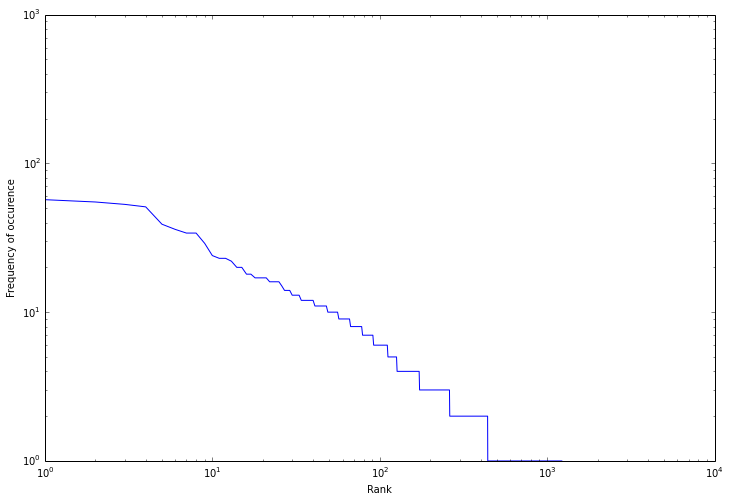

In [37]:
# Confirm the Zipf's law
freqs = get_word_freq(X_data, y_eval < 2)
np_occ = np.array([cnt for word, cnt in freqs])
np_rank = np.array([i for i, pair in enumerate(freqs)])

plt.figure(figsize=(12, 8))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Rank")
plt.ylabel("Frequency of occurence")
plt.plot(np_rank, np_occ)
plt.show()

In [38]:
# Stats: Words in -ve reviews that are not in +ve reviews
TOP_K = 50

freqs_pos = get_word_freq(X_data, y_eval == 1)
freqs_neg = get_word_freq(X_data, y_eval == 0)

words_pos = set([word for word, cnt in freqs_pos])
words_neg = set([word for word, cnt in freqs_neg])

ranks_pos = get_ranks(freqs_pos)
ranks_neg = get_ranks(freqs_neg)

words_exc_neg = words_neg - words_pos
freqs_exc_neg = []

for word_exc_neg in words_exc_neg:
    freqs_exc_neg.append(freqs_neg[ranks_neg[word_exc_neg]])

freqs_exc_neg = sorted(freqs_exc_neg, reverse=True, key=lambda x: x[1])

for word_exc, count_exc in freqs_exc_neg[:TOP_K]:
    print word_exc, count_exc

write_cloud(freqs_exc_neg[:TOP_K], "results/cloud.exc.neg.txt")

available 5
paying 5
ruling 4
wages 4
administration 4
instead 4
taxes 3
optional 3
received 3
given 3
families 3
department 3
president 3
visas 3
laws 3
9/11 2
violation 2
children 2
adding 2
avoid 2
pledge 2
favor 2
disney 2
extend 2
incentives 2
payroll 2
little 2
reported 2
buy 2
allows 2
broken 2
65% 2
gao 2
illegals 2
incentive 2
congress 2
bonus 2
left 2
limited 1
facto 1
fica 1
hands 1
lack 1
thomas 1
actions 1
trade 1
disabled 1
liberty 1
committee 1
facts 1
Written to file: results/cloud.exc.neg.txt


In [39]:
# Stat: Who did we lose from 60 percentile to 90 percentile and what were their names and comments
LOW_PERC = 60
HIGH_PERCS = [65, 70, 75, 80, 85, 90, 95, 99]

for high_perc in [90]:
    low_amr = get_amr(names_data, first_name_cache, last_name_cache, LOW_PERC, exclude_intl_names=True)
    high_amr = get_amr(names_data, first_name_cache, last_name_cache, high_perc, exclude_intl_names=True)

    lost_idx = (1-high_amr) * low_amr
    lost_votes = y_eval[lost_idx == 1]
    print("Percentage of +ve among lost: {}".format(np.sum(lost_votes) / float(len(lost_votes))))

Percentage of +ve among lost: nan


/Library/Python/2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


LABEL=0


AssertionError: incompatible sizes: argument 'height' must be length 20 or scalar

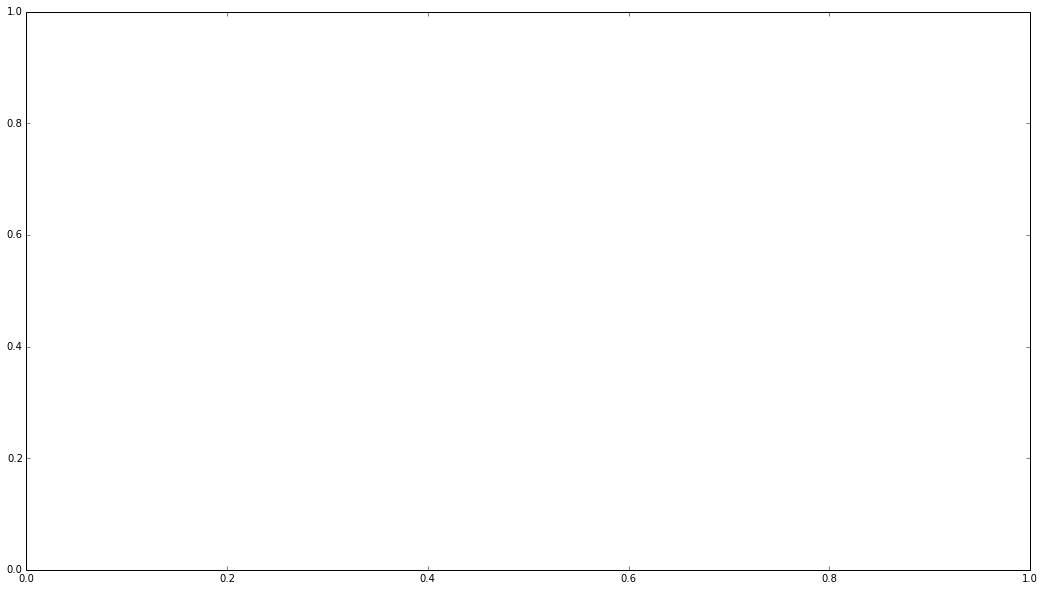

In [40]:
# Stat: Most common names 
def get_top_names(names, cond):
    names = names_data[cond]
    last_names_cnt_cache = collections.defaultdict(int)
    
    for first_name, last_name in names:
        last_names_cnt_cache[last_name] += 1
        
    return sorted([(last_name, float(cnt)/len(names)) for last_name, cnt in last_names_cnt_cache.iteritems()], 
                  reverse=True, key=lambda x: x[1])

labels = [0,1]
TOP_K = 20
index = np.arange(0, TOP_K*2, 2)

for label in labels:
    print("LABEL=%d" % label)
    names = get_top_names(names_data, y_eval == label)
    np_names, np_freq = zip(*names[:TOP_K])
    
    plt.figure(figsize=(18,10))
    bar_width = 0.70
    
    rects1 = plt.bar(index, np.array(np_freq), bar_width,
                 color='r', label="Frequency in %s-labeled comments" % label)
                 
    plt.xticks(index + bar_width, np_names)
    plt.ylabel("Frequency of occurence of names")
    plt.legend()
    plt.show()

In [619]:
import dill
dill.dump(P, open("model/P.p", "wb" ))
dill.dump(Pc, open("model/Pc.p", "wb" ))